In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer 
from IPython.display import display
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
%matplotlib inline

In [2]:
test_data = pd.read_csv("test.csv")
test_labels = pd.read_csv("test_labels.csv")
train_data = pd.read_csv("train.csv")
test_merged = pd.merge(test_data, test_labels,on='id')

In [3]:
headers = train_data.columns.values[2:]

total_size = train_data.shape[0]
comments_count = {
    "total_size": train_data.shape[0],
    "total_toxic": 0,
    "total_severe_toxic": 0,
    "total_obscene": 0,
    "total_threat": 0,
    "total_insult": 0,
    "total_identity_hate": 0,
    "total_clear": 0,
}

categories_count = {
    "0": 0,
    "1": 0,
    "2": 0,
    "3": 0,
    "4": 0,
    "5": 0,
    "6": 0
}

from collections import defaultdict
categories_dict = defaultdict(lambda: 0)

for ind in train_data.index:
    is_clear = True
        
    categories = []
    
    for header in headers:
        if train_data[header][ind] > 0:
            count_header_name = 'total_' + header
            comments_count[count_header_name] += 1
            categories.append(header)
            
            is_clear = False

    if is_clear:
        comments_count['total_clear'] += 1
    
    categories_count[str(len(categories))] += 1
    categories_dict[", ".join(categories)] += 1

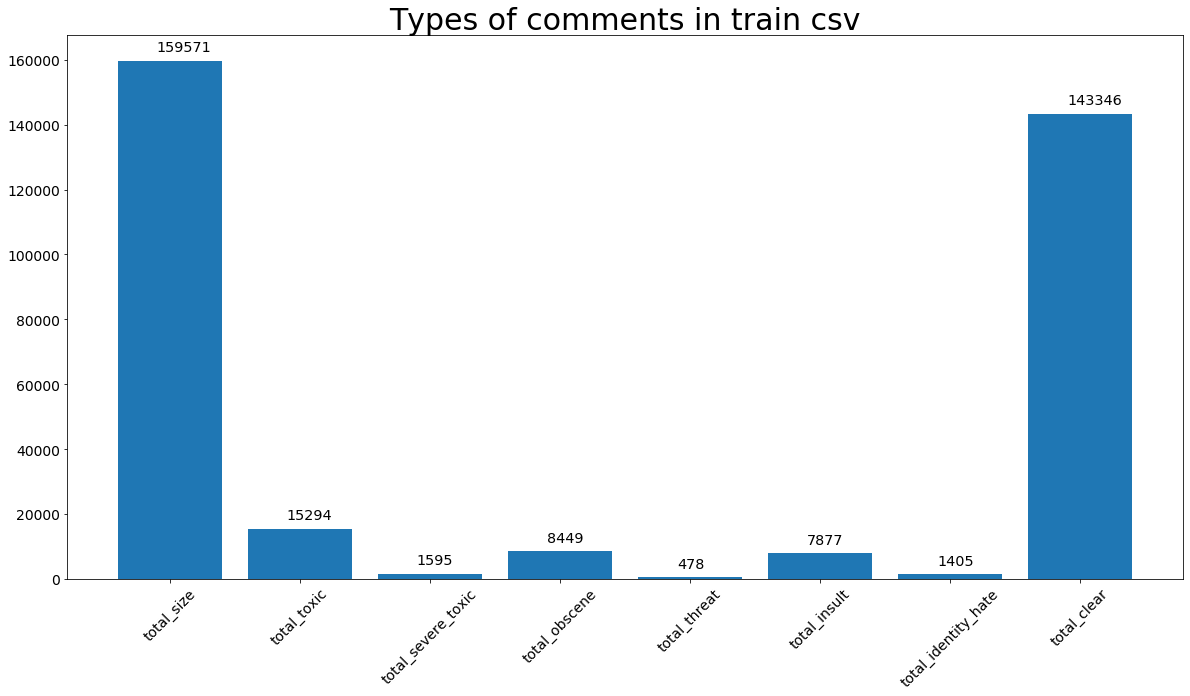

In [4]:
plt.figure(figsize=(20,10))
plt.bar(comments_count.keys(), comments_count.values())
plt.yticks(fontsize=14)
plt.xticks(fontsize=14, rotation=45)
plt.title('Types of comments in train csv', fontsize=30)

for index, value in enumerate(comments_count.values()):
    plt.text(index - 0.1, value + 3000, str(value), fontsize='x-large')

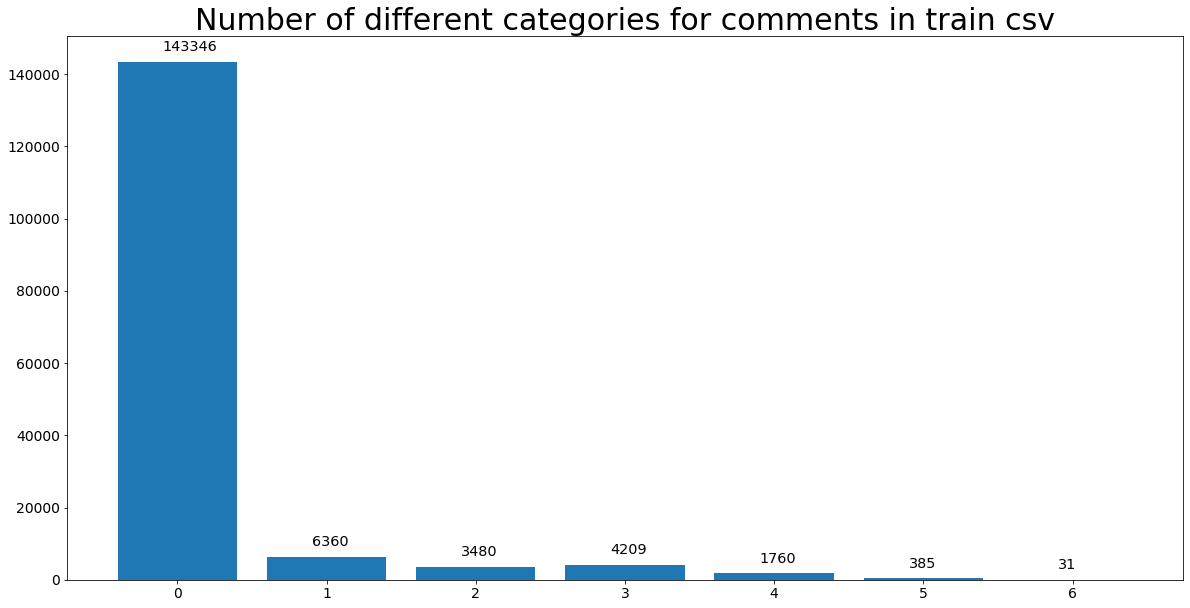

In [5]:
plt.figure(figsize=(20,10))
plt.bar(categories_count.keys(), categories_count.values())
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Number of different categories for comments in train csv', fontsize=30)

for index, value in enumerate(categories_count.values()):
    plt.text(index - 0.1, value + 3000, str(value), fontsize='x-large')

In [6]:
l = list(zip(list(categories_dict.keys()), list(categories_dict.values())))
headers_list = [""] + headers.ravel().tolist()
l = sorted(l, key=lambda kv: (kv[0].count(", "), [headers_list.index(k) for k in kv[0].split(", ")], kv))
l = np.array(l)
cat_df = pd.DataFrame({"categories": l[:,0], "amount": l[:,1]})
pd.set_option('max_colwidth', 800)
display(cat_df)

,categories,amount
0,,143346
1,toxic,5666
2,obscene,317
3,threat,22
4,insult,301
5,identity_hate,54
6,"toxic, severe_toxic",41
7,"toxic, obscene",1758
8,"toxic, threat",113
9,"toxic, insult",1215


,comment_type,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,toxic,1.000000,0.308619,0.676515,0.157058,0.647518,0.266009
1,severe_toxic,0.308619,1.000000,0.403014,0.123601,0.375807,0.201600
2,obscene,0.676515,0.403014,1.000000,0.141179,0.741272,0.286867
3,threat,0.157058,0.123601,0.141179,1.000000,0.150022,0.115128
4,insult,0.647518,0.375807,0.741272,0.150022,1.000000,0.337736
5,identity_hate,0.266009,0.201600,0.286867,0.115128,0.337736,1.000000


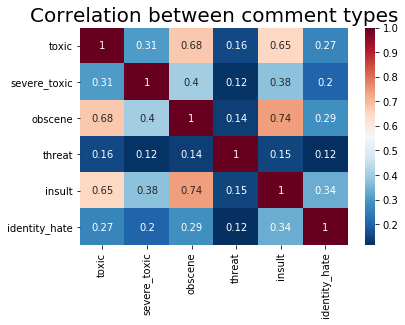

In [7]:
correlation = {
    "comment_type":[],
    "toxic": [],
    "severe_toxic": [],
    "obscene": [],
    "threat": [],
    "insult": [],
    "identity_hate": []
}

for header in headers:
    correlation['comment_type'].append(header)
    for second_header in headers:
        correlation[second_header].append(train_data[header].corr(train_data[second_header]))

df_correlation = pd.DataFrame(correlation)
display(df_correlation)

df_correlation = df_correlation.drop('comment_type', axis=1)
sns.heatmap(df_correlation, xticklabels=df_correlation.columns, yticklabels=df_correlation.columns, annot=True, cmap = "RdBu_r")
plt.title('Correlation between comment types', fontsize = 20)
plt.show()

In [8]:
print("TF IDF per comment type")
for header in headers:
    comment_type_data = train_data.loc[train_data[header] == 1]

    tvec = TfidfVectorizer(min_df=.0025, stop_words='english', strip_accents='unicode', analyzer='word', max_features=1000)
    tvec_weights = tvec.fit_transform(comment_type_data['comment_text'])
    weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
    weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
    print("Comment type: " + header)
    display(weights_df.sort_values(by='weight', ascending=False).head(25))

TF IDF per comment type
Comment type: toxic


,term,weight
365,fuck,0.048554
369,fucking,0.027905
531,like,0.025065
962,wikipedia,0.024403
286,don,0.023051
493,just,0.021927
788,shit,0.020961
644,page,0.020670
838,stop,0.017783
505,know,0.016876


Comment type: severe_toxic


,term,weight
309,fuck,0.121331
317,fucking,0.057208
109,bitch,0.042105
714,suck,0.038581
668,shit,0.037263
73,ass,0.030283
75,asshole,0.028726
218,dick,0.028243
195,cunt,0.027097
277,faggot,0.023548


Comment type: obscene


,term,weight
357,fuck,0.074229
364,fucking,0.042188
768,shit,0.029312
131,bitch,0.025861
825,suck,0.025560
94,ass,0.023765
520,like,0.023383
937,wikipedia,0.022646
280,don,0.022110
484,just,0.020487


Comment type: threat


,term,weight
236,die,0.060658
461,kill,0.054482
332,fucking,0.040469
328,fuck,0.038878
353,going,0.037050
72,ass,0.027702
406,hope,0.026299
496,ll,0.024089
249,don,0.023890
716,shit,0.023484


Comment type: insult


,term,weight
341,fuck,0.064564
348,fucking,0.037663
121,bitch,0.025839
762,shit,0.024854
510,like,0.024574
818,suck,0.022986
929,wikipedia,0.022942
86,ass,0.021321
265,don,0.021245
815,stupid,0.020961


Comment type: identity_hate


,term,weight
376,gay,0.058507
361,fuck,0.050249
329,faggot,0.037820
367,fucking,0.037186
641,nigger,0.035319
550,like,0.026239
796,shit,0.026194
100,ass,0.021855
136,bitch,0.021444
675,people,0.016455


In [9]:
print("TF IDF per all comment types")
toxic_data = train_data[(train_data['toxic'] == 1) | (train_data['severe_toxic'] == 1) | (train_data['obscene'] == 1) |
                       (train_data['threat'] == 1) | (train_data['insult'] == 1) | (train_data['identity_hate'] == 1)]

tvec = TfidfVectorizer(min_df=.0025, stop_words='english', strip_accents='unicode', analyzer='word', max_features=1000)
tvec_weights = tvec.fit_transform(toxic_data['comment_text'])
weights = np.asarray(tvec_weights.mean(axis=0)).ravel().tolist()
weights_df = pd.DataFrame({'term': tvec.get_feature_names(), 'weight': weights})
display(weights_df.sort_values(by='weight', ascending=False).head(25))

TF IDF per all comment types


,term,weight
364,fuck,0.046758
368,fucking,0.027060
525,like,0.025474
963,wikipedia,0.024501
286,don,0.023212
489,just,0.022261
639,page,0.021098
785,shit,0.020430
837,stop,0.017628
499,know,0.017223


In [10]:
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/eldoras/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
# toxic_data = train_data[(train_data['toxic'] == 1) | (train_data['severe_toxic'] == 1) | (train_data['obscene'] == 1) |
#                        (train_data['threat'] == 1) | (train_data['insult'] == 1) | (train_data['identity_hate'] == 1)]
# TSNE only for toxic data didn't show too much

list_comment_types = []
dict_comment_types = {}
for index, row in train_data.iterrows():
    row_comment_types = []
    for header in headers:
        if row[header] == 1:
            row_comment_types.append(header)
    dict_comment_types[index] = row_comment_types
    list_comment_types.append(index)
    
list_comments = list(train_data["comment_text"])

tagged_data = [TaggedDocument(words=word_tokenize(comment.lower()), tags=[i]) for i, comment in enumerate(list_comments)]

In [10]:
# load Doc2Vec model instead of training
# model = Doc2Vec.load("d2v_do_v100_e500.model")

In [11]:
# train Doc2Vec model
max_epochs = 500
alpha = 0.025
vec_size = 100

model = Doc2Vec(vector_size=vec_size,
                alpha=alpha, 
                min_alpha=0.00025,
                min_count=1,
                dm=1)

model.build_vocab(tagged_data)

for epoch in range(max_epochs):
    if epoch % 10 == 0:
        print('iteration {0}'.format(epoch))

    model.train(tagged_data,
                total_examples=model.corpus_count,
                epochs=model.epochs)
    
    model.alpha -= 0.0002
    model.min_alpha = model.alpha

model.save("d2v_do_v100_e500.model")

iteration 0
iteration 10
iteration 20
iteration 30
iteration 40
iteration 50
iteration 60
iteration 70
iteration 80
iteration 90
iteration 100
iteration 110
iteration 120
iteration 130
iteration 140
iteration 150
iteration 160
iteration 170
iteration 180
iteration 190
iteration 200
iteration 210
iteration 220
iteration 230
iteration 240
iteration 250
iteration 260
iteration 270
iteration 280
iteration 290
iteration 300
iteration 310
iteration 320
iteration 330
iteration 340
iteration 350
iteration 360
iteration 370
iteration 380
iteration 390
iteration 400
iteration 410
iteration 420
iteration 430
iteration 440
iteration 450
iteration 460
iteration 470
iteration 480
iteration 490


In [16]:
def plotScatter(df, keyword):
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot(1, 1, 1)

    pos_found_x = []
    pos_found_y = []
    found_comments = []

    pos_rest_x = []
    pos_rest_y = []
    
    for comment_id, pos in df.iterrows():
        comment_types = dict_comment_types[comment_id + 1]
        comment_text = train_data.loc[comment_id + 1, 'comment_text']

        if keyword in comment_types:
            pos_found_x.append(pos['x'])
            pos_found_y.append(pos['y'])
        else:
            pos_rest_x.append(pos['x'])
            pos_rest_y.append(pos['y'])

    ax.scatter(pos_rest_x, pos_rest_y, c='blue')       
    ax.scatter(pos_found_x, pos_found_y, c='red')

In [14]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

doc_tags = list(dict_comment_types.keys())
doc_tags = [tag-1 for tag in doc_tags]
X = model.docvecs.vectors_docs

# TSNE trainining model
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)
tsne_dataframe = pd.DataFrame(X_tsne, index=doc_tags, columns=['x', 'y'])
tsne_dataframe.to_csv("tsne_dataframe.csv")

# read TSNE results from dataframe
# tsne_dataframe = pd.read_csv("tsne_dataframe.csv", index_col=0)

,x,y
-1,7.698508,20.129217
0,9.678493,2.527723
1,1.523571,20.188364
2,5.880564,21.901602
3,-11.986114,-8.170191
...,...,...
159565,7.199978,27.435522
159566,3.890691,-6.674529
159567,-20.779505,10.761739
159568,17.310986,2.794489


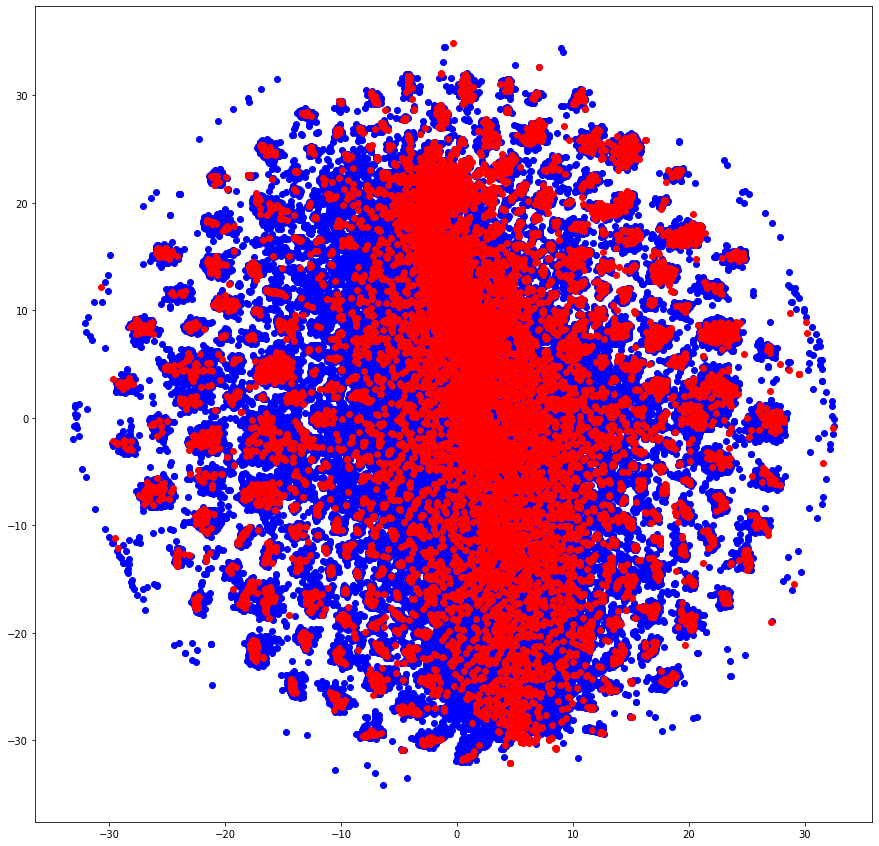

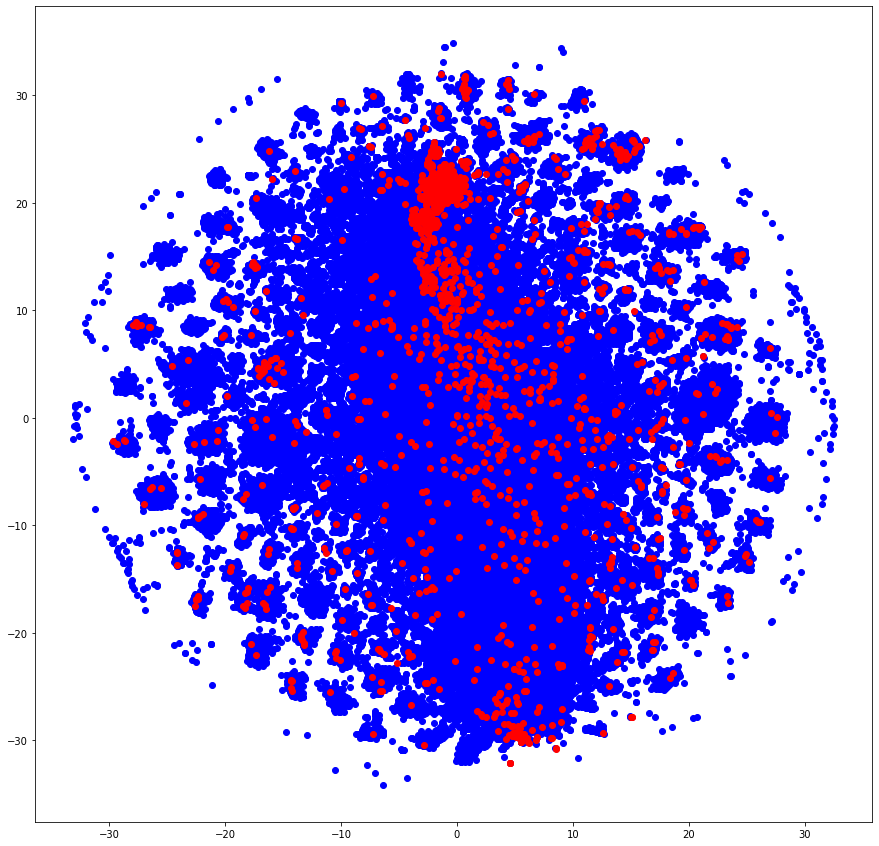

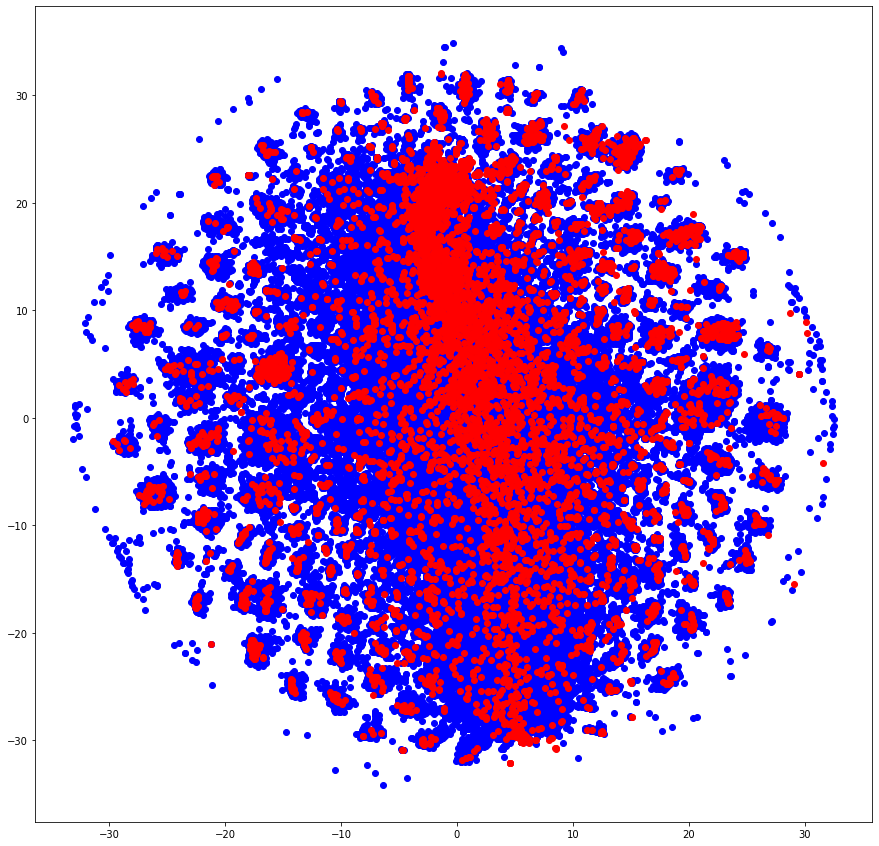

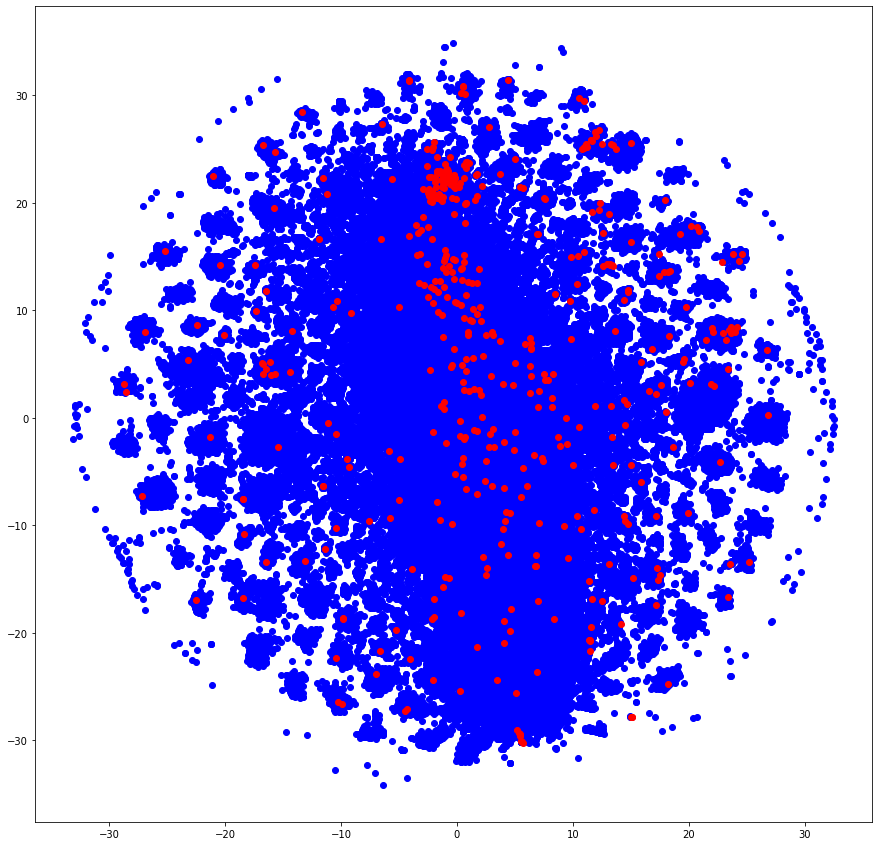

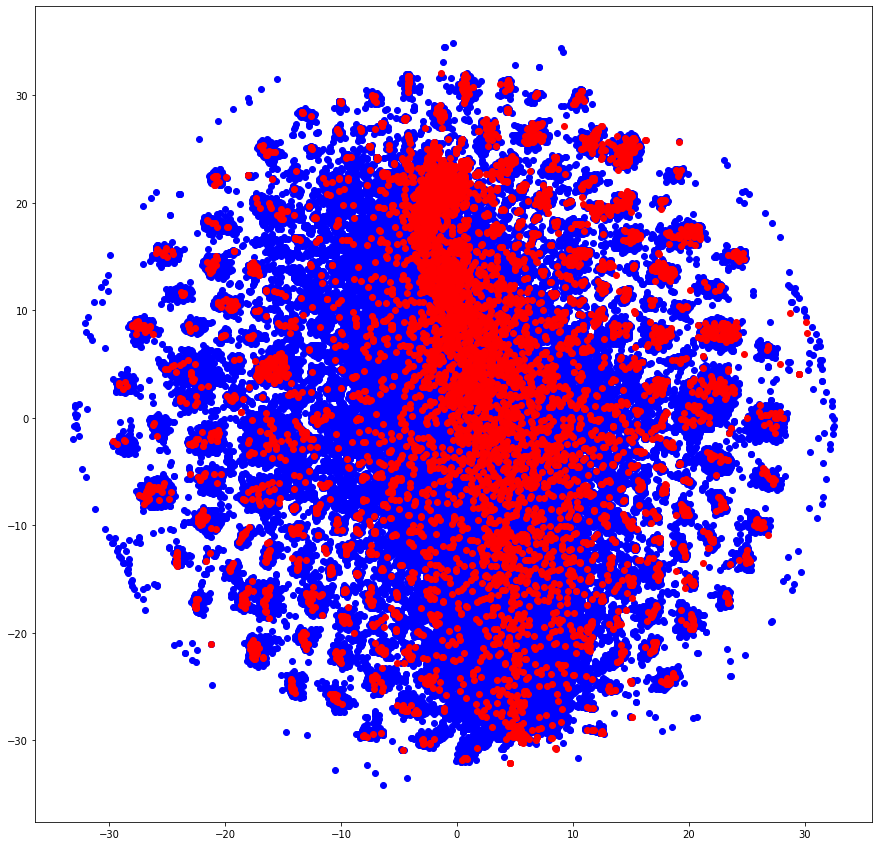

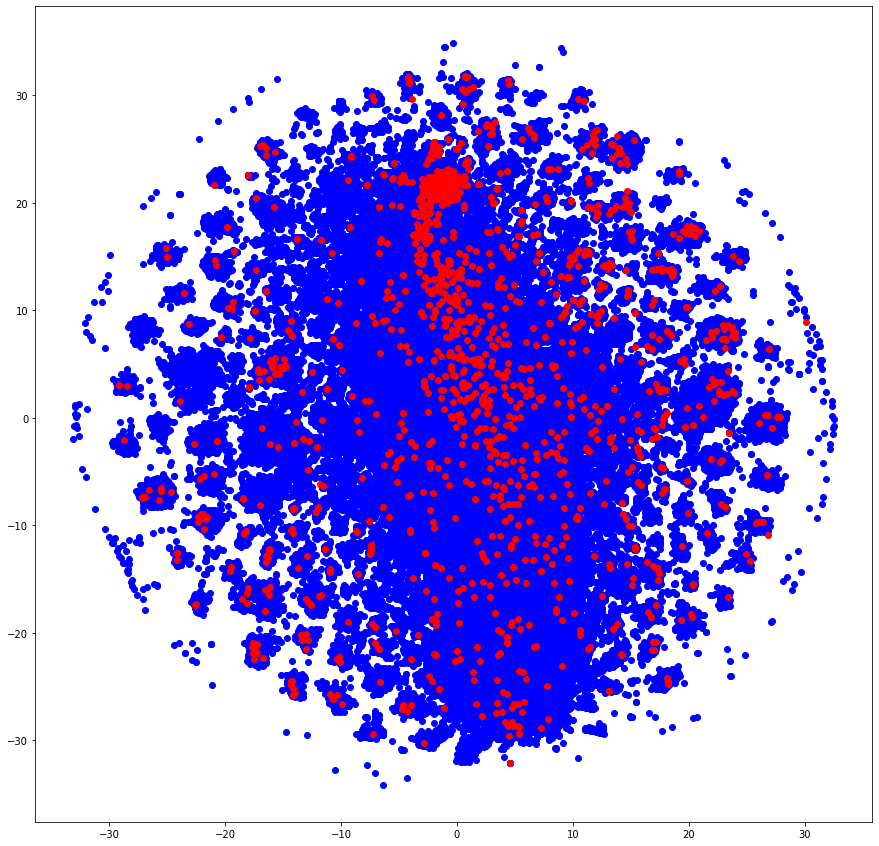

In [17]:
display(tsne_dataframe)

plotScatter(df=tsne_dataframe, keyword="toxic")
plotScatter(df=tsne_dataframe, keyword="severe_toxic")
plotScatter(df=tsne_dataframe, keyword="obscene")
plotScatter(df=tsne_dataframe, keyword="threat")
plotScatter(df=tsne_dataframe, keyword="insult")
plotScatter(df=tsne_dataframe, keyword="identity_hate")